In [357]:
import torch
import pandas as pd

torch.__version__

'2.8.0+cu126'

In [358]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [359]:
#device = 'cpu'

In [360]:
from sklearn.model_selection import train_test_split

In [361]:
data = pd.read_csv('../data/processed_trip_duration.csv')
data.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,in_nyc_center?,distance,hour_1,hour_2,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,is_it_weekday?,is_it_first_vendor?(else 2nd)
0,1,-73.953918,40.778873,-73.963875,40.771164,400,1,1199.769914,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2,-73.988312,40.731743,-73.994751,40.694931,1100,1,4123.945168,0,1,...,0,0,0,0,0,0,0,0,1,1
2,2,-73.997314,40.721458,-73.948029,40.774918,1635,1,7250.435807,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,-73.961670,40.759720,-73.956779,40.780628,1141,1,2358.286547,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,-73.993614,40.751884,-73.995422,40.723862,1455,1,3115.641570,0,0,...,0,0,0,0,0,0,0,0,0,0


In [362]:
y, X = data['trip_duration'].values, data.drop(columns=['trip_duration']).values
y = y.reshape(-1, 1)
X.shape, y.shape

((655757, 33), (655757, 1))

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((524605, 33), (131152, 33), (524605, 1), (131152, 1))

In [364]:
from torch.utils.data import TensorDataset, DataLoader

In [365]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [366]:
train_ds = TensorDataset(torch.from_numpy(X_train).type(torch.float32).to(device), torch.from_numpy(y_train).type(torch.float32).to(device))

train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)

test_ds = TensorDataset(torch.from_numpy(X_test).type(torch.float32).to(device), torch.from_numpy(y_test).type(torch.float32).to(device))

test_dl = DataLoader(test_ds, batch_size=512, shuffle=True)

# Creating FCNN Classification model

In [367]:
import numpy as np

In [368]:
import torch
import torch.nn as nn
import torch.optim as optim

In [369]:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(33, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [370]:
model = RegressionNet().to(device)
loss_function = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [371]:
num_epochs = 200
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_dl:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    epoch_loss.append(loss.item())

Epoch [1/200], Loss: 616200.1250
Epoch [2/200], Loss: 190782.7188
Epoch [3/200], Loss: 124912.2578
Epoch [4/200], Loss: 95956.9375
Epoch [5/200], Loss: 140239.6094
Epoch [6/200], Loss: 86850.7812
Epoch [7/200], Loss: 107938.9297
Epoch [8/200], Loss: 107784.6484
Epoch [9/200], Loss: 104093.1797
Epoch [10/200], Loss: 103777.8281
Epoch [11/200], Loss: 86787.1562
Epoch [12/200], Loss: 69781.6406
Epoch [13/200], Loss: 80285.1875
Epoch [14/200], Loss: 113672.6875
Epoch [15/200], Loss: 80102.1094
Epoch [16/200], Loss: 99406.2656
Epoch [17/200], Loss: 71549.9531
Epoch [18/200], Loss: 91980.2578
Epoch [19/200], Loss: 80054.5859
Epoch [20/200], Loss: 87396.8750
Epoch [21/200], Loss: 77882.2891
Epoch [22/200], Loss: 108369.6953
Epoch [23/200], Loss: 75360.2891
Epoch [24/200], Loss: 97390.5391
Epoch [25/200], Loss: 92374.1328
Epoch [26/200], Loss: 99021.7109
Epoch [27/200], Loss: 82513.9141
Epoch [28/200], Loss: 86084.1250
Epoch [29/200], Loss: 82256.3828
Epoch [30/200], Loss: 85771.5078
Epoch [31

In [372]:
import matplotlib.pyplot as plt

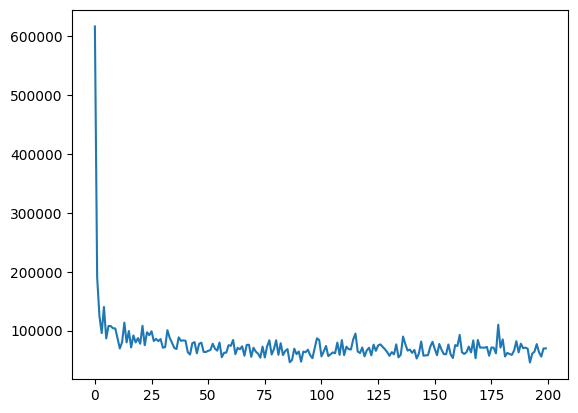

In [373]:
plt.plot(epoch_loss)

In [374]:
model.eval()
with torch.no_grad():
    outputs = model(torch.from_numpy(X_test).float().to(device))
    _, y_pred = torch.max(outputs, 1)

y_pred = y_pred.to('cpu').numpy()

## Evaluation on test data

In [375]:
model.eval()

with torch.no_grad():
    all_predictions = []
    all_labels = []

    for batch_x, batch_y in test_dl:
        outputs = model(batch_x)
        
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [376]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [377]:

r2 = r2_score(all_labels, all_predictions)
print(f'R2: {r2:.4f}')

mae = mean_absolute_error(all_labels, all_predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

mse = mean_squared_error(all_labels, all_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

R2: 0.7175
Mean Absolute Error (MAE): 179.0001
Mean Squared Error (MSE): 64699.9297
Root Mean Squared Error (RMSE): 254.3618


## Evaluation on train data
If metrics on train >>> than on test => overfitting

In [378]:
model.eval()

with torch.no_grad():
    all_predictions = []
    all_labels = []

    for batch_x, batch_y in train_dl:
        outputs = model(batch_x)
        
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [379]:

r2 = r2_score(all_labels, all_predictions)
print(f'R2: {r2:.4f}')

mae = mean_absolute_error(all_labels, all_predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

mse = mean_squared_error(all_labels, all_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

R2: 0.7184
Mean Absolute Error (MAE): 179.3792
Mean Squared Error (MSE): 65322.0469
Root Mean Squared Error (RMSE): 255.5818
